In [1]:
import re
import os
from copy import copy
import csv
import pickle as pkl
from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from scipy.stats import zscore,mannwhitneyu
from sklearn.preprocessing import normalize
import scipy.sparse as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad

from utils.max_coverage import select_kmer_greedy_iterative

sns.set_style("white")

COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 'truetype'
%load_ext autoreload
%autoreload 2
%load_ext jupyter_spaces

Download data if not available

In [12]:
%%bash
set -e 
if ! [ -d "./downloads/neoantigen_candidates/" ]; then 
    rm -rf "./downloads"
    mkdir -p "./downloads"
    cd "./downloads"
    wget -c "https://crc-atlas.s3.amazonaws.com/data.tar.gz"; 
    tar -xzvf "data.tar.gz"
fi

Load isoform quantification in TCGA

In [2]:
tcga_coad_isoform_level_patient_agg=pd.read_csv("downloads/neoantigen_candidates/tcga_coad_isoform_level_patient_agg.csv",index_col=0)

The following 12 isoforms were identified to be tumor specific isoforms in both in-house and TCGA data, that are also able to produce novel 9-mers in their ORFs.

In [3]:
selected_isoforms=[
    "TCONS_00042881",
    "TCONS_00044960",
    "TCONS_00112393",
    "TCONS_00078414",
    "TCONS_00031983",
    "TCONS_00051680",
    "TCONS_00107919",
    "TCONS_00085591",
    "TCONS_00024309",
    "TCONS_00085535",
    "TCONS_00116629",
    "TCONS_00044985",
]

The following heatmap verifies their tumor-specific expression pattern

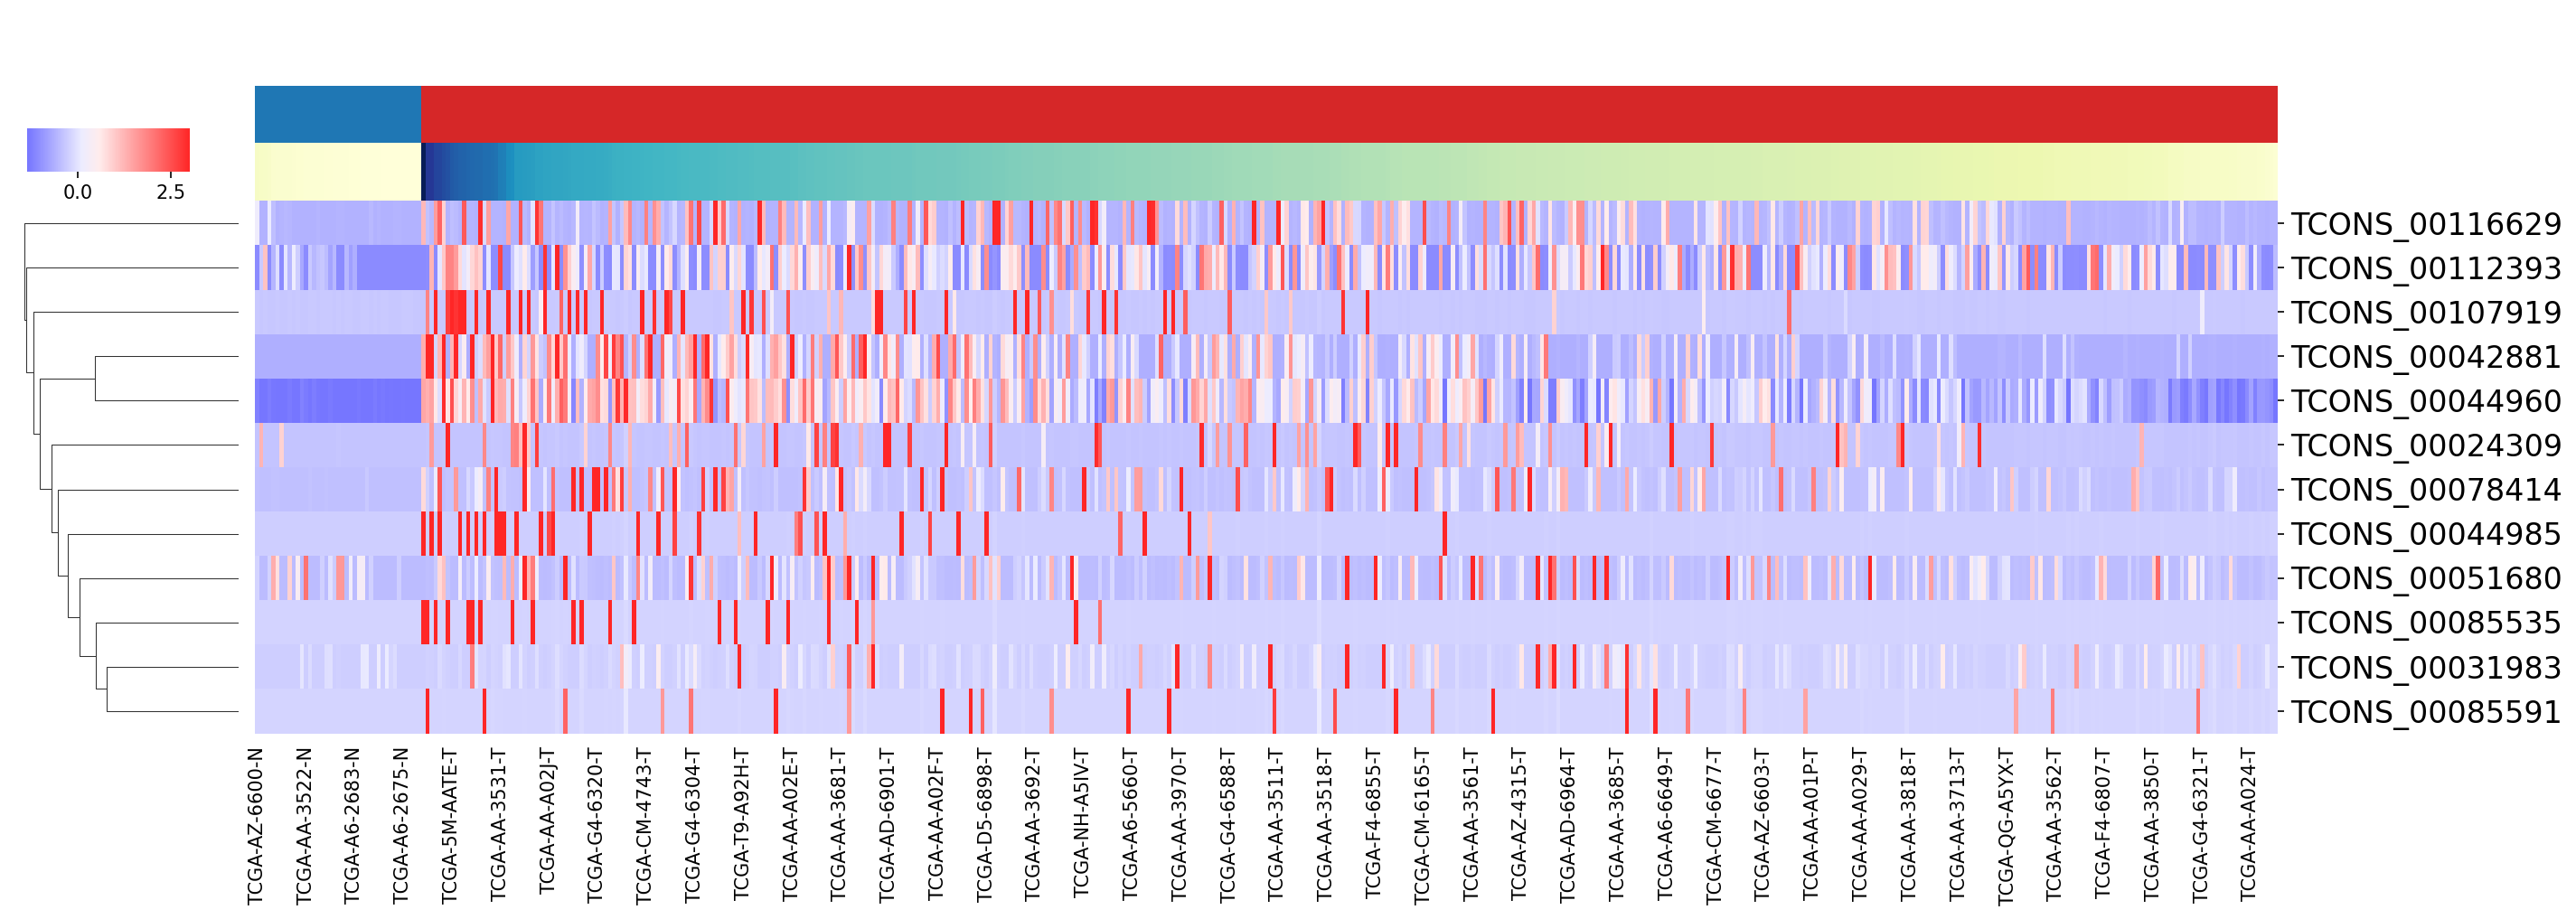

In [4]:
def plot_isoform_expression(
    isoform_expression_table,transcript_list,
    row_cluster=False,col_cluster=False,
    row_labels=None,col_labels=None,
    row_values=None,col_values=None,
    row_linkage=None,col_linkage=None,
    z_score=False,show_max=True
):
    min_height=0.3
    height_per_transcript=0.5
    figure_height=min_height+len(transcript_list)*height_per_transcript
    col_cmap=[sns.color_palette("tab10")[i] for i in [0,3,1,2,4,5,6,7,8,9]]
    # process_table
    plot_df=isoform_expression_table.loc[transcript_list,:]
    
    if z_score:
        plot_df=plot_df.apply(zscore,axis=1)
        plot_df=plot_df.clip(-3,3)
    if show_max:
        plot_df.loc["MAX",:]=plot_df.max(axis=0)
    plot_df=plot_df.astype(np.float32)
    
    row_colors=list()
    col_colors=list()
    # row_labels
    if row_labels is not None:
        row_palette=dict(zip(sorted(row_labels.unique()),sns.color_palette("muted")))
        row_colors.append([row_palette[i] for i in row_labels.values])

    
    # col_labels
    if col_labels is not None:
        col_palette=dict(zip(sorted(col_labels.unique()),col_cmap))
        col_colors.append([col_palette[i] for i in col_labels.values])

    
    if row_values is not None:
        row_cmap=plt.get_cmap("bwr")
        row_colors.append([row_cmap(i) for i in row_values.values])
    
    if col_values is not None:
        col_cmap=plt.get_cmap("YlGnBu")
        col_colors.append([col_cmap(i) for i in col_values.values])
    
    if len(row_colors)==0:
        row_colors=None
        
    if len(col_colors)==0:
        col_colors=None
        
    if row_labels is not None:
        plot_df=plot_df.loc[row_labels.index,]
        
    if col_labels is not None:
        plot_df=plot_df.loc[:,col_labels.index]
    
    # plot
    heatmap_cmap=mpl.colors.LinearSegmentedColormap.from_list(
        'pos_cmap',
        sns.color_palette('bwr',n_colors=12)[2:]
    )
    
    cg=sns.clustermap(
        plot_df,
        row_cluster=row_cluster,
        col_cluster=col_cluster,
        cmap=heatmap_cmap,
        dendrogram_ratio=0.1,
        colors_ratio=0.08,
        row_colors=row_colors,
        col_colors=col_colors,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        cbar_kws={"orientation":"horizontal"},
        cbar_pos=(0.02, 0.8, 0.06, 0.05)
    )
    
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(),rotation=0,fontsize=16)

    _=cg.ax_heatmap.set_ylabel(None)
    _=cg.ax_heatmap.set_xlabel(None)
    plt.gcf().set_size_inches((20,figure_height))


def sort_and_normalize_columns(df,col_labels):  
    df_mean=df.mean(axis=0).sort_values(ascending=False)
    normal_cols=df_mean.index[df_mean.index.str.endswith("-N")]
    tumor_cols=df_mean.index[df_mean.index.str.endswith("-T")]
    df_mean_min_max=(df_mean-df_mean.min())/(df_mean.max()-df_mean.min())
    return df_mean_min_max,list(normal_cols)+list(tumor_cols)

col_labels=pd.Series(
    data=tcga_coad_isoform_level_patient_agg.columns.map(lambda x: 'tumor' if x.split('-')[3]=='T' else 'normal'),
    index=tcga_coad_isoform_level_patient_agg.columns
)

expr=tcga_coad_isoform_level_patient_agg.loc[selected_isoforms,:]
col_values,col_order=sort_and_normalize_columns(expr,col_labels)

expr=expr.loc[:,col_order]
col_labels=col_labels[col_order]
col_values=col_values[col_order]

plot_isoform_expression(
    expr,
    expr.index,
    col_labels=col_labels,col_values=col_values,
    z_score=True,show_max=False,col_cluster=False,row_cluster=True
)

We next load the metadata of the isoforms, the possible 9mers that could be generated from their ORFs, as well as their binding profiles against HLA alleles of TCGA patients

In [5]:
isoform_table_selection=pd.read_csv("downloads/neoantigen_candidates/isoform_table.csv")
kmer_table_selection=pd.read_csv("downloads/neoantigen_candidates/kmer_table.csv")
kmer_HLA_table=pd.read_csv("downloads/neoantigen_candidates/kmer_HLA_table.csv",index_col="kmer_seq")

Here is a small example of optimizing the neoepitope panel from a list of transcripts
- `kmer_binding_sets` contains the HLA alleles that each neoepitope (kmer) binds to
- `HLA_weights` contains the weight of each HLA allele, which could represent the allele frequency or other measurement of importance of each allele.
- `kmers_by_transcripts` contains the neoepitopes (kmer) that each isoform can generate

In [6]:
kmer_binding_sets={
    "kmer1":{"A1","A2"},
    "kmer2":{"A3"},
    "kmer3":{"A5"},
    "kmer4":{"A3","A4"},
    "kmer5":{"A6","A7"},
    "kmer6":{"A8","A9"},
    "kmer7":{"A10","A11"},
    "kmer8":{"A10","A11"},
    "kmer9":{"A6","A7"},
    "kmer10":{"A6","A12"},
    "kmer11":{"A6","A7"},
    "kmer12":{"A8","A9"}
}

HLA_weights={
    "A1":1,
    "A2":1,
    "A3":1,
    "A4":1,
    "A5":1,
    "A6":1,
    "A7":1,
    "A8":1,
    "A9":5,
    "A10":1,
    "A11":1,
    "A12":1
}

kmers_by_transcripts={
    "t1":["kmer1","kmer2","kmer3","kmer4"],
    "t2":["kmer5","kmer6","kmer7","kmer8"],
    "t3":["kmer9","kmer10","kmer11","kmer12"]
}

After invoking the greedy algorithm through `select_kmer_greedy_iterative`, the neoepitopes selected for each isoform is returned in `kmers_by_transcripts_optimized`, and the covered HLA alleles are in `HLA_covered`. 

We recommend the algorithm to try to select two neoepitopes from each isoform (`n_kmers_per_transcript=2`), although the result is not guaranteed exactly.

In [7]:
kmers_by_transcripts_optimized,HLA_covered=select_kmer_greedy_iterative(
    kmer_binding_sets,
    HLA_weights,
    kmers_by_transcripts=kmers_by_transcripts,
    n_kmers_per_transcript=2
)
print(kmers_by_transcripts_optimized)
print(HLA_covered)

# kmers: 12
# identities: 12
From t1 selecting kmer: kmer1, weight_gain: 2
From t1 selecting kmer: kmer4, weight_gain: 2
From t2 selecting kmer: kmer6, weight_gain: 6
From t2 selecting kmer: kmer5, weight_gain: 2
From t3 selecting kmer: kmer10, weight_gain: 1
weight of covered set: 13
[('t1', ['kmer1', 'kmer4']), ('t2', ['kmer6', 'kmer5']), ('t3', ['kmer10'])]
{'A9', 'A3', 'A1', 'A2', 'A8', 'A7', 'A6', 'A4', 'A12'}


We next move on to a real-world example.
We use the four isoforms the existence of which have been confirmed by experiments: `TCONS_00042881`, `TCONS_00044960`, `TCONS_00112393`, and `TCONS_00078414`.

In [8]:
def prepare_binding_data(
    isoform_table,
    kmer_table,
    kmer_HLA_table,
    isoform_list=None
):
    if isoform_list is None:
        isoform_list=list(isoform_table["Isoform"])
        
    kmers_by_transcripts=dict()
    for iso in isoform_list:
        kmers=kmer_table.query("isoforms.str.contains('{}')".format(iso),engine='python')["kmer"].tolist()
        kmers_by_transcripts[iso]=set(kmers)
        
    all_kmers=set()
    for kmers in kmers_by_transcripts.values():
        all_kmers.update(kmers)
    kmer_binding_sets=dict()
    binding_threshold=2
    for kmer in all_kmers:
        kmer_binding_sets[kmer]=set(kmer_HLA_table.columns[kmer_HLA_table.loc[kmer,:]<binding_threshold])
    HLA_weights={k:1 for k in kmer_HLA_table.columns}
    return kmers_by_transcripts,HLA_weights,kmer_binding_sets

experimentally_confirmed_isoforms=[
    'TCONS_00042881',  # CPNE7
    'TCONS_00044960',  # CPNE7
    'TCONS_00112393', # ZC3HAV1L
    'TCONS_00078414'  # STMN3
]

kmers_by_transcripts,HLA_weights,kmer_binding_sets=prepare_binding_data(
    isoform_table_selection,
    kmer_table_selection,
    kmer_HLA_table,
    isoform_list=experimentally_confirmed_isoforms
)

Similarly, we optimize the neoepitope panel for the four isoforms.

In [9]:
kmers_by_transcripts_optimized,HLA_covered=select_kmer_greedy_iterative(
    kmer_binding_sets,HLA_weights,
    kmers_by_transcripts=kmers_by_transcripts,
    n_kmers_per_transcript=6
)

# kmers: 157
# identities: 301
From TCONS_00042881 selecting kmer: HAQHTREVL, weight_gain: 106
From TCONS_00042881 selecting kmer: RHAQHTREV, weight_gain: 33
From TCONS_00042881 selecting kmer: VLPAETHTA, weight_gain: 25
From TCONS_00042881 selecting kmer: REVLPAETH, weight_gain: 23
From TCONS_00042881 selecting kmer: LPAETHTAH, weight_gain: 8
From TCONS_00042881 selecting kmer: HTREVLPAE, weight_gain: 6
From TCONS_00044960 selecting kmer: MPFLCPQQY, weight_gain: 28
From TCONS_00044960 selecting kmer: LFPPVKSSI, weight_gain: 15
From TCONS_00044960 selecting kmer: QQYYILLIL, weight_gain: 11
From TCONS_00044960 selecting kmer: VLEGLRQGR, weight_gain: 10
From TCONS_00044960 selecting kmer: NVSVLEGLR, weight_gain: 6
From TCONS_00044960 selecting kmer: FLCPQQYYI, weight_gain: 4
From TCONS_00112393 selecting kmer: LLPEIISTY, weight_gain: 7
From TCONS_00112393 selecting kmer: EIISTYKHM, weight_gain: 1
From TCONS_00078414 selecting kmer: QTQEAQVLK, weight_gain: 12
From TCONS_00078414 selecting

We then plot the binding profile of the optimized neoepitope panel against known HLA alleles of the TCGA patients.

Note that the result is slightly different from the one reported in the manuscript. This is because we additionally considered the overlapping between the neoepitope with the mass spectrometry subsequence in the manuscript version to further guarantee their existence. However, the general conclusion still holds.

# weak binding 301/301 = 100.00%
# strong binding 247/301 = 82.06%


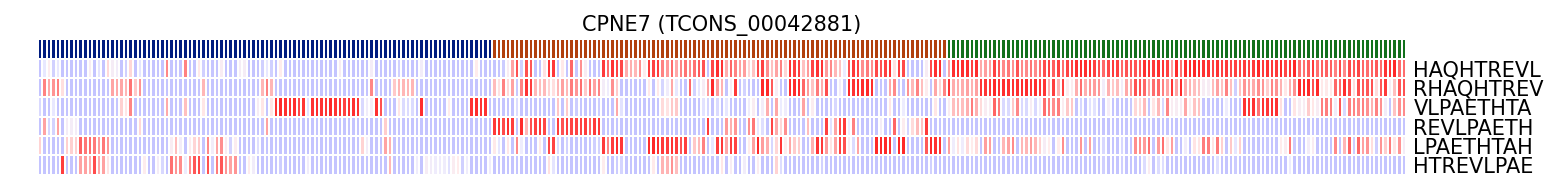

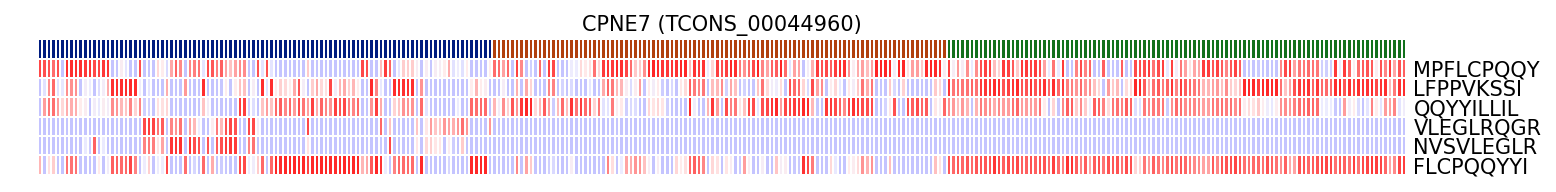

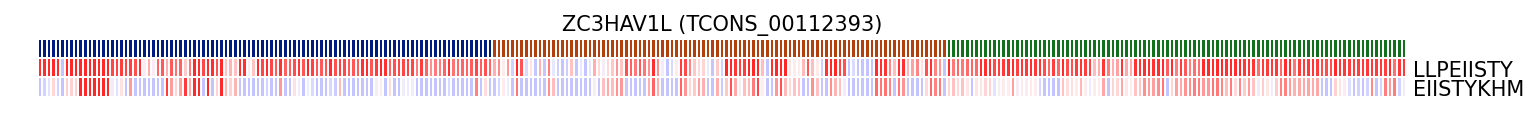

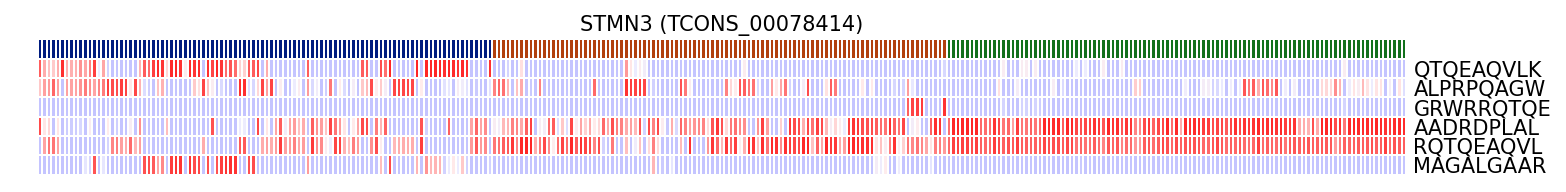

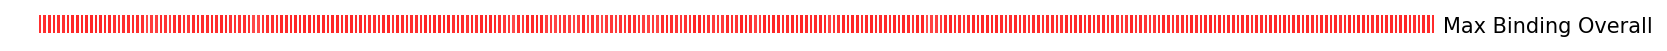

In [10]:
def heatmap_HLA_binding_one(
    plot_df,
    row_labels=None,col_labels=None,
    row_colors=None,col_colors=None,
    row_ticklabels=True,col_ticklabels=True,
    linewidths=0.01,figure_width=10,
    xlabel=None,
    ylabel=None,
    y_invert=False,
    min_height=0,
    height_per_kmer=0.15
):
    
    if col_labels is not None:
        figure_height=min_height+(plot_df.shape[0]+1)*height_per_kmer
    else:
        figure_height=min_height+(plot_df.shape[0])*height_per_kmer
    # preprocess
    plot_df=plot_df.astype(np.float32)
    
    row_color_codes=sns.color_palette("dark")
    col_color_codes=sns.color_palette("dark")
    # row_labels
    if row_labels is not None:
        row_palette=dict(zip(sorted(row_labels.unique()),row_color_codes))
        row_colors=[row_palette[i] for i in row_labels.values]

    # col_labels
    if col_labels is not None:
        col_labels=col_labels.sort_values()
        col_palette=dict(zip(sorted(col_labels.unique()),col_color_codes))
        col_colors=[col_palette[i] for i in col_labels.values]

    if row_labels is not None:
        plot_df=plot_df.loc[row_labels.index,]
    if col_labels is not None:
        plot_df=plot_df.loc[:,col_labels.index]
        
    muted_bwr=mpl.colors.LinearSegmentedColormap.from_list(
        'pos_cmap',
        sns.color_palette('bwr',n_colors=12)[4:]
    )
    # plot
    if y_invert:
        if row_colors is not None:
            row_colors=row_colors[::-1]
            col_colors=col_colors
        plot_df=plot_df.iloc[::-1,:]
    cg=sns.clustermap(
        plot_df,
        row_cluster=False,
        col_cluster=False,
        vmin=90,vmax=100,cmap=muted_bwr,linewidths=linewidths,
        dendrogram_ratio=0.01,
        colors_ratio=(1/(plot_df.shape[1]+1),1/(plot_df.shape[0]+1)),
        row_colors=row_colors,
        col_colors=col_colors
    )
    
    # PP figure
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(),rotation=0)

    cg.ax_cbar.set_visible(False)
    _=cg.ax_heatmap.set_ylabel(ylabel)
    _=cg.ax_heatmap.yaxis.set_label_position("left")
    cg.ax_heatmap.tick_params(axis='both',length=0)
    if not row_ticklabels:
        _=cg.ax_heatmap.set_yticklabels([])
        _=cg.ax_heatmap.set_yticks([])
    if not col_ticklabels:
        _=cg.ax_heatmap.set_xticklabels([]) 
        _=cg.ax_heatmap.set_xticks([]) 
    _=cg.ax_heatmap.set_xlabel(None)
    if cg.ax_col_colors is not None:
        _=cg.ax_col_colors.set_xlabel(xlabel)
        _=cg.ax_col_colors.xaxis.set_label_position("top")
    else:
        _=cg.ax_heatmap.set_xlabel(xlabel)
        _=cg.ax_heatmap.xaxis.set_label_position("top")
    plt.gcf().set_size_inches((figure_width,figure_height))
    return cg

def heatmap_HLA_binding(
    kmer_HLA_table,
    kmers_by_isoform,
    isoform_metadata,
    topn=0,
    figure_width=10,
    linewidths=0.01,
    min_height=0,
    height_per_kmer=0.15
):
    if True:
        col_labels = pd.Series(
            data=kmer_HLA_table.columns.map(lambda x: x[:5]),
            index=kmer_HLA_table.columns
        )
    else:
        col_labels= pd.Series(
            data=["default"]*len(kmer_HLA_table.columns),
            index=kmer_HLA_table.columns
        )
    
    
    plot_df=100-kmer_HLA_table
    
    max_binding_list=list()
    n_binding_list=list()
    cluster_grids=list()
    for i,(isoform,kmers_list) in enumerate(kmers_by_isoform):
        plot_df_sub=plot_df.loc[kmers_list,:]
        if topn>0:
            kmers_list=plot_df_sub.mean(axis=1).sort_values(ascending=False).iloc[:topn].index.tolist()
            plot_df_sub=plot_df_sub.loc[kmers_list,:]

        maxb=plot_df_sub.max(axis=0)
        nb=(plot_df_sub>98).sum(axis=0)
        
        max_binding_list.append(maxb)
        n_binding_list.append(nb)
        
        
        xlabel="{} ({})".format(isoform_metadata.loc[isoform,"GeneSymbol"],isoform)

        cg=heatmap_HLA_binding_one(
            plot_df_sub,
            row_labels=None,
            col_labels=col_labels,
            xlabel=xlabel,
            col_ticklabels=False,
            row_ticklabels=True,
            figure_width=figure_width,
            linewidths=linewidths,
            min_height=min_height,
            height_per_kmer=height_per_kmer
        )
        cluster_grids.append(cg)
    max_binding_concat=pd.concat(max_binding_list,axis=1).T
    max_binding_final=pd.DataFrame(max_binding_concat.max(axis=0)).T
    max_binding_final.index=["Max Binding Overall"]
    print("# weak binding {}/{} = {:.2f}%".format(
        (max_binding_final.iloc[0]>98).sum(),
        max_binding_final.shape[1],
        (max_binding_final.iloc[0]>98).mean()*100
    ))
    print("# strong binding {}/{} = {:.2f}%".format(
        (max_binding_final.iloc[0]>99.5).sum(),
        max_binding_final.shape[1],
        (max_binding_final.iloc[0]>99.5).mean()*100
    ))
    cg=heatmap_HLA_binding_one(
        max_binding_final.loc[:,col_labels.sort_values().index],
        col_ticklabels=False,
        row_ticklabels=True,
        figure_width=figure_width,
        linewidths=linewidths
    )
    cluster_grids.append(cg)
    return max_binding_final,cluster_grids

kmers_by_transcripts_plot=kmers_by_transcripts_optimized

isoform_metadata=isoform_table_selection.set_index("Isoform").loc[
    [t[0] for t in kmers_by_transcripts_plot],["GeneSymbol"]
]

max_binding_final,cluster_grids=heatmap_HLA_binding(
    kmer_HLA_table,
    kmers_by_isoform=kmers_by_transcripts_plot,
    isoform_metadata=isoform_metadata,
    linewidths=0.2,
    figure_width=10,
    min_height=0,
    height_per_kmer=0.15
)